In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from sklearn.preprocessing import MinMaxScaler
import pickle

In [2]:
df = pd.read_csv('spam.csv', encoding='latin1')  # Or any other appropriate encoding

In [3]:
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
1905,ham,"There're some people by mu, I'm at the table b...",NaN,NaN,NaN
1792,spam,WIN: We have a winner! Mr. T. Foley won an iPo...,NaN,NaN,NaN
3199,ham,Just curious because my cuz asked what I was u...,NaN,NaN,NaN
3513,ham,I always chat with you. In fact i need money c...,NaN,NaN,NaN
804,ham,K I'll be there before 4.,NaN,NaN,NaN


In [4]:
df.shape

(5572, 5)

## Data Cleaning

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [6]:
#drop last 3 columns
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [7]:
df.sample(5)

,v1,v2
329,ham,I'm reading the text i just sent you. Its mean...
1074,ham,Aight ill get on fb in a couple minutes
2196,ham,"Not much, just some textin'. How bout you?"
5551,ham,Wen did you get so spiritual and deep. That's ...
2292,ham,:-( that's not v romantic!


In [8]:
#renaming the columns
df.rename(columns={'v1':'target', 'v2':'text'}, inplace=True)

In [9]:
df.sample(5)

,target,text
1366,ham,Bbq this sat at mine from 6ish. Ur welcome 2 come
4020,ham,We have to pick rayan macleran there.
4009,spam,Wan2 win a Meet+Greet with Westlife 4 U or a m...
3333,ham,"That's fine, have him give me a call if he kno..."
4058,spam,Moby Pub Quiz.Win a å£100 High Street prize if...


In [10]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [11]:
df['target'] = encoder.fit_transform(df['target'])

In [12]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
#missing values
df.isnull().sum()

target    0
text      0
dtype: int64

In [14]:
#check for duplicate values
df.duplicated().sum()

403

In [15]:
#remove duplicates
df = df.drop_duplicates(keep='first')

In [16]:
df.duplicated().sum()

0

In [17]:
df.shape

(5169, 2)

## EDA

In [18]:
df.head()

,target,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [19]:
df['target'].value_counts()

0    4516
1     653
Name: target, dtype: int64

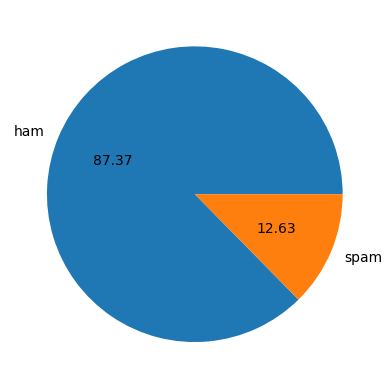

In [20]:
plt.pie(df['target'].value_counts(), labels=['ham','spam'], autopct="%0.2f")
plt.show()

In [21]:
#Data is imbalanced

In [22]:
#nltk.download('punkt')

In [23]:
#Number of characters
df['numCharacters'] = df['text'].apply(len)

In [24]:
df.head()

,target,text,numCharacters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [25]:
#Number of Words
#df['text'].apply(lambda x:nltk.word_tokenize(x))
df['numWords'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))

In [26]:
df.head()

,target,text,numCharacters,numWords
0,0,"Go until jurong point, crazy.. Available only ...",111,24
1,0,Ok lar... Joking wif u oni...,29,8
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37
3,0,U dun say so early hor... U c already then say...,49,13
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15


In [27]:
#Number of Sentences
#df['text'].apply(lambda x:nltk.sent_tokenize(x))
df['numSentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [28]:
df.head()

,target,text,numCharacters,numWords,numSentences
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2
1,0,Ok lar... Joking wif u oni...,29,8,2
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2
3,0,U dun say so early hor... U c already then say...,49,13,1
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1


In [29]:
df[['numCharacters', 'numWords', 'numSentences']].describe()

,numCharacters,numWords,numSentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [30]:
#Ham Messages
df[df['target'] == 0][['numCharacters', 'numWords', 'numSentences']].describe()

,numCharacters,numWords,numSentences
count,4516.000000,4516.000000,4516.000000
mean,70.459256,17.123782,1.820195
std,56.358207,13.493970,1.383657
min,2.000000,1.000000,1.000000
25%,34.000000,8.000000,1.000000
50%,52.000000,13.000000,1.000000
75%,90.000000,22.000000,2.000000
max,910.000000,220.000000,38.000000


In [31]:
#Spam Messages
df[df['target'] == 1][['numCharacters', 'numWords', 'numSentences']].describe()

,numCharacters,numWords,numSentences
count,653.000000,653.000000,653.000000
mean,137.891271,27.667688,2.970904
std,30.137753,7.008418,1.488425
min,13.000000,2.000000,1.000000
25%,132.000000,25.000000,2.000000
50%,149.000000,29.000000,3.000000
75%,157.000000,32.000000,4.000000
max,224.000000,46.000000,9.000000


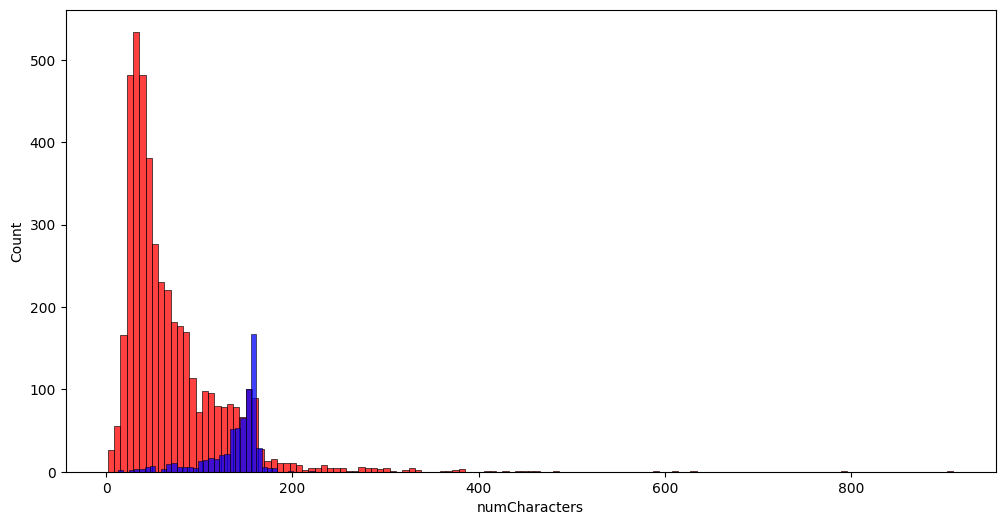

In [32]:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['target']==0]['numCharacters'],color='red')
sns.histplot(df[df['target']==1]['numCharacters'],color='blue')
plt.show()

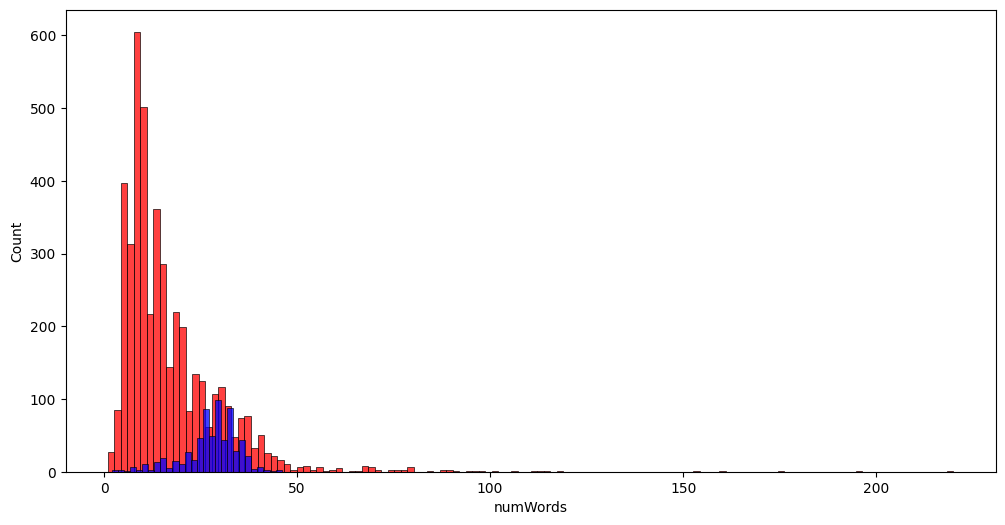

In [33]:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['target']==0]['numWords'],color='red')
sns.histplot(df[df['target']==1]['numWords'],color='blue')
plt.show()

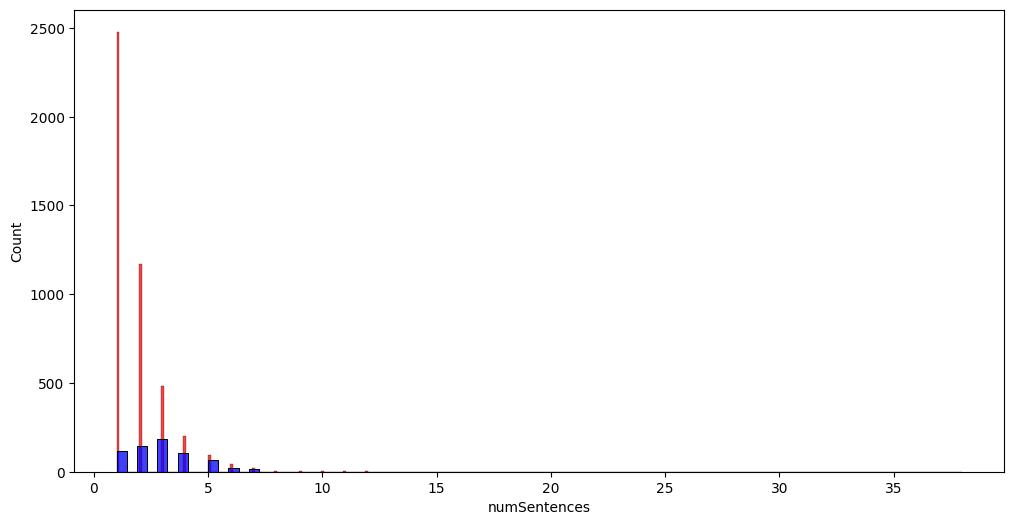

In [34]:
plt.figure(figsize=(12, 6))
sns.histplot(df[df['target']==0]['numSentences'],color='red')
sns.histplot(df[df['target']==1]['numSentences'],color='blue')
plt.show()

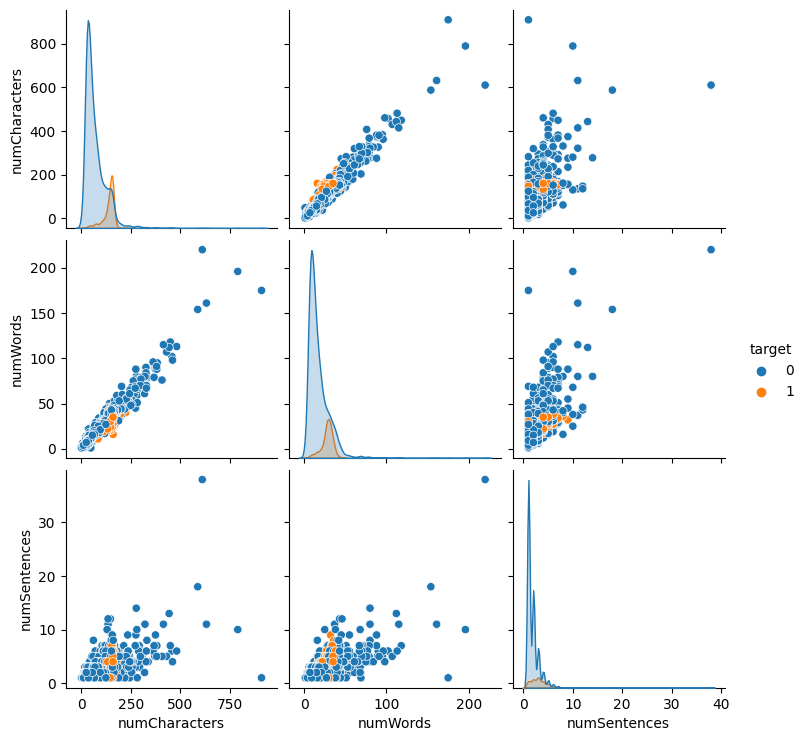

In [35]:
sns.pairplot(df, hue='target')
plt.show()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_6944\40291281.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()
C:\Users\ahmed\AppData\Local\Temp\ipykernel_6944\40291281.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


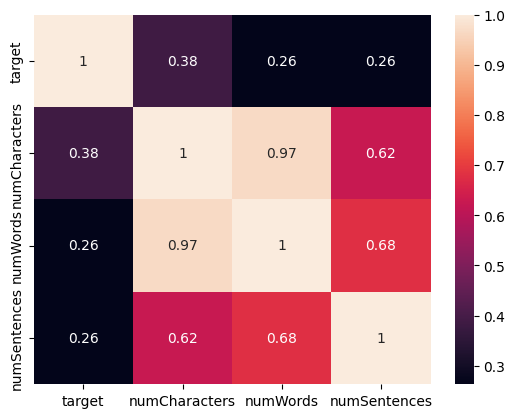

In [36]:
df.corr()
sns.heatmap(df.corr(), annot=True)
plt.show()

## Data Preprocessing
    # Lower 
    # Tokenization
    # Removing Special Characters
    # Removing Stop Words & Punctuation
    # Stemming

In [37]:
def transformText(text):
    #Lower
    text = text.lower()
    #Tokenization
    text = nltk.word_tokenize(text)
    
    alnumText = []
    #Removing Special Characters
    for i in text:
        if i.isalnum():
            alnumText.append(i)
            
    text = alnumText[:]
    alnumText.clear()
    #Removing Stop Words & Punctuation
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            alnumText.append(i)

    text = alnumText[:]
    alnumText.clear()
    #Stemming
    ps = PorterStemmer()
    for i in text:
        alnumText.append(ps.stem(i))

    return " ".join(alnumText)

In [38]:
#df['text'][0]
transformText('Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...')

'go jurong point crazi avail bugi n great world la e buffet cine got amor wat'

In [39]:
df['transformedText'] = df['text'].apply(transformText)

In [40]:
df.head()

,target,text,numCharacters,numWords,numSentences,transformedText
0,0,"Go until jurong point, crazy.. Available only ...",111,24,2,go jurong point crazi avail bugi n great world...
1,0,Ok lar... Joking wif u oni...,29,8,2,ok lar joke wif u oni
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155,37,2,free entri 2 wkli comp win fa cup final tkt 21...
3,0,U dun say so early hor... U c already then say...,49,13,1,u dun say earli hor u c alreadi say
4,0,"Nah I don't think he goes to usf, he lives aro...",61,15,1,nah think goe usf live around though


In [41]:
wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white')

In [42]:
spamWWC = wc.generate(df[df['target']==1]['transformedText'].str.cat(sep=" "))

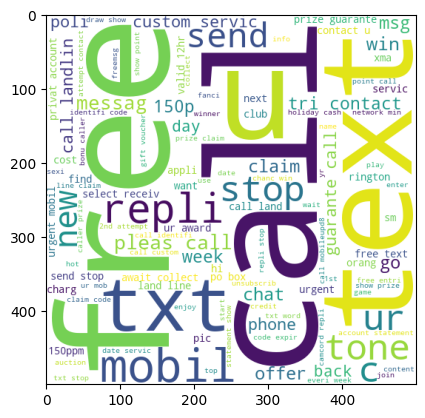

In [43]:
plt.imshow(spamWWC)
plt.show()

In [44]:
hamWWC = wc.generate(df[df['target']==0]['transformedText'].str.cat(sep=" "))

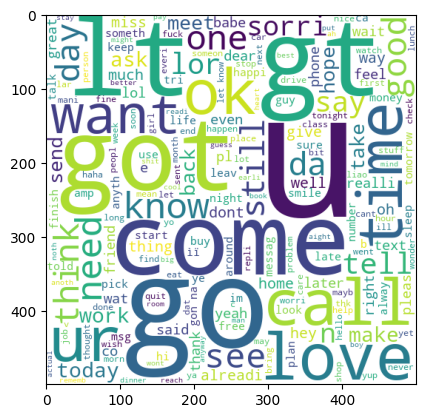

In [45]:
plt.imshow(hamWWC)
plt.show()

In [46]:
spamCorpus = []
for msg in df[df['target'] == 1]['transformedText'].tolist():
    for word in msg.split():
        spamCorpus.append(word)

In [47]:
len(spamCorpus)

9939

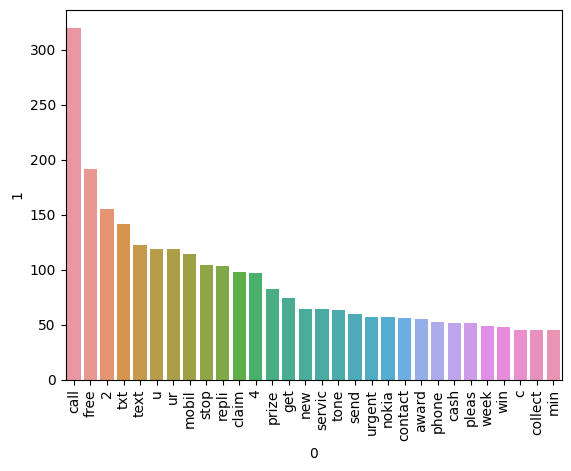

In [48]:
spam_counts = Counter(spamCorpus).most_common(30)
temp = pd.DataFrame(spam_counts)

# Plotting
sns.barplot(x=temp[0], y=temp[1])
plt.xticks(rotation='vertical')
plt.show()

In [49]:
hamCorpus = []
for msg in df[df['target'] == 0]['transformedText'].tolist():
    for word in msg.split():
        hamCorpus.append(word)

In [50]:
len(hamCorpus)

35404

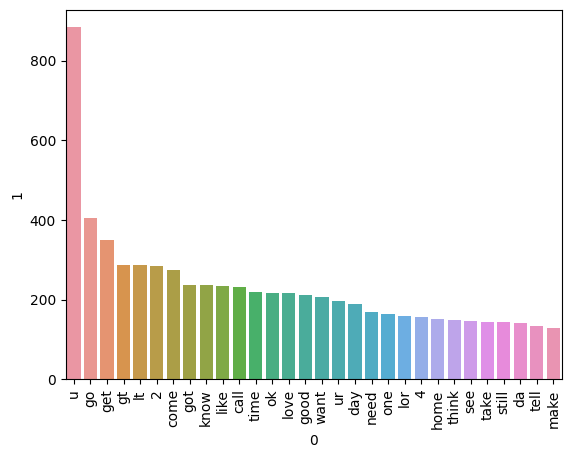

In [51]:
ham_counts = Counter(hamCorpus).most_common(30)
temp = pd.DataFrame(ham_counts)

# Plotting
sns.barplot(x=temp[0], y=temp[1])
plt.xticks(rotation='vertical')
plt.show()

## Model Building

In [52]:
#cv = CountVectorizer()
tfidf = TfidfVectorizer(max_features=3000)

In [53]:
X = tfidf.fit_transform(df['transformedText']).toarray()

In [54]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [55]:
X.shape

(5169, 3000)

In [56]:
Y = df['target'].values

In [57]:
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.2, random_state=2)

In [58]:
#gnb=GaussianNB()
mnb=MultinomialNB()
#bnb=BernoulliNB()

In [62]:
#gnb.fit(Xtrain, Ytrain)
#Ypred1 = gnb.predict(Xtest)
#print(accuracy_score(Ytest, Ypred1))
#print(confusion_matrix(Ytest, Ypred1))
#print(precision_score(Ytest, Ypred1))"""

In [60]:
mnb.fit(Xtrain, Ytrain)
Ypred2 = mnb.predict(Xtest)
print(accuracy_score(Ytest, Ypred2))
print(confusion_matrix(Ytest, Ypred2))
print(precision_score(Ytest, Ypred2)) #tfidf --> MNB

0.9709864603481625
[[896   0]
 [ 30 108]]
1.0


In [63]:
#bnb.fit(Xtrain, Ytrain)
#Ypred3 = bnb.predict(Xtest)
#print(accuracy_score(Ytest, Ypred3))
#print(confusion_matrix(Ytest, Ypred3))
#print(precision_score(Ytest, Ypred3))"""

In [65]:
pickle.dump(tfidf, open('vectorizer.pkl', 'wb'))
pickle.dump(mnb, open('model.pkl', 'wb'))